In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
train_dataset=pd.read_csv('dataset/train_dataset.csv', index_col='date')
validation_dataset=pd.read_csv('dataset/validation_dataset.csv',index_col='date')

In [3]:
X=train_dataset.iloc[:,1:-2]
y=train_dataset.target

In [5]:
train=0.8
test=0.2
era=len(train_dataset.index.unique())
train_era=int(era*train)
test_era=era-train_era
X_train=X[X.index<X.index.unique()[train_era]]
y_train=y[y.index<y.index.unique()[train_era]]
X_test=X[X.index>=X.index.unique()[train_era]]
y_test=y[y.index>=y.index.unique()[train_era]]

In [6]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [7]:
xgreg1= XGBRegressor(gamma=0.25,reg_lambda=2,colsample_bytree=0.5, colsample_bylevel=0.5, colsample_bynode=0.5,
                     num_parallel_tree=4,eta=0.05, max_depth=6,n_estimators=200, min_child_weight=2,subsample=0.5)

In [8]:
xgreg1=xgreg1.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='rmse',eval_set=[(X_test,y_test)])

[0]	validation_0-rmse:0.28898
[1]	validation_0-rmse:0.28869
[2]	validation_0-rmse:0.28843
[3]	validation_0-rmse:0.28821
[4]	validation_0-rmse:0.28797
[5]	validation_0-rmse:0.28778
[6]	validation_0-rmse:0.28759
[7]	validation_0-rmse:0.28740
[8]	validation_0-rmse:0.28721
[9]	validation_0-rmse:0.28704
[10]	validation_0-rmse:0.28689
[11]	validation_0-rmse:0.28677
[12]	validation_0-rmse:0.28662
[13]	validation_0-rmse:0.28648
[14]	validation_0-rmse:0.28635
[15]	validation_0-rmse:0.28622
[16]	validation_0-rmse:0.28610
[17]	validation_0-rmse:0.28600
[18]	validation_0-rmse:0.28591
[19]	validation_0-rmse:0.28583
[20]	validation_0-rmse:0.28576
[21]	validation_0-rmse:0.28569
[22]	validation_0-rmse:0.28562
[23]	validation_0-rmse:0.28556
[24]	validation_0-rmse:0.28550
[25]	validation_0-rmse:0.28545
[26]	validation_0-rmse:0.28538
[27]	validation_0-rmse:0.28532
[28]	validation_0-rmse:0.28528
[29]	validation_0-rmse:0.28523
[30]	validation_0-rmse:0.28516
[31]	validation_0-rmse:0.28513
[32]	validation_0-

In [9]:
# Define error metrics
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


y_pred_train = xgreg1.predict(X_train)
print('rmse for train dataset: {}'.format(rmse(y_train,y_pred_train)))

y_pred_test = xgreg1.predict(X_test)
print('rmse for test dataset: {}'.format(rmse(y_test,y_pred_test)))

rmse for train dataset: 0.2667699822238961
rmse for test dataset: 0.28449353425003737


In [25]:
# save to JSON
xgreg1.save_model("xgreg1_1018_final.json")
# save to text format
xgreg1.save_model("xgreg1_1018_final.txt")
# save to model format
xgreg1.save_model("xgreg1_1018_final.model")

In [10]:
groups=X_train.groupby('date').size().to_frame('size')['size'].to_numpy()
groups_eval=X_test.groupby('date').size().to_frame('size')['size'].to_numpy()

                rmse
date                
2018-04-29  0.265977
2018-05-06  0.266383
2018-05-13  0.261142
2018-05-20  0.266825
2018-05-27  0.269862
...              ...
2020-12-27  0.266923
2021-01-03  0.263757
2021-01-10  0.261680
2021-01-17  0.265366
2021-01-24  0.271183

[144 rows x 1 columns]


<IPython.core.display.Javascript object>


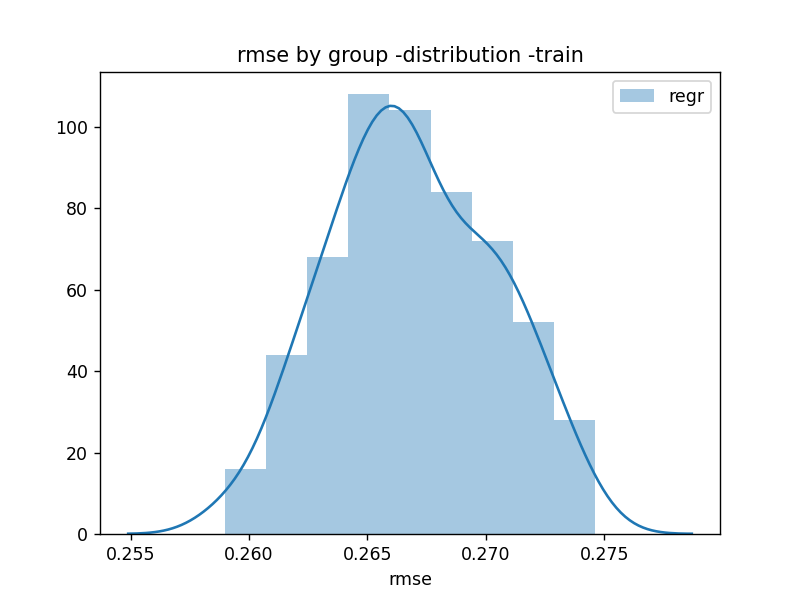

Text(0.5, 1.0, 'rmse by group -distribution -train')

In [11]:
predictionXG1 = pd.DataFrame()
predictionXG1['date'] = list(X_train.index)
predictionXG1.set_index(['date'],inplace=True)
predictionXG1['prediction'] = y_pred_train
predictionXG1['label']=y_train
predictionXG1['delta']=predictionXG1.prediction-predictionXG1.label
predictionXG1.prediction.max()
trainCmp=predictionXG1.copy()
trainCmp.columns=['pred','target','delta_or']
indexTrainList=trainCmp.index.unique().to_list()
groupSizeTrain=pd.DataFrame(data={'groupSize':groups}, index=indexTrainList)
trainCmp=trainCmp.join(groupSizeTrain, how='left')
trainCmp.index.name='date'

np.sqrt(mean_squared_error(trainCmp['pred'],trainCmp['target']))
def rmse( g ):
    
    rmse = np.sqrt( mean_squared_error( g['target'], g['pred'] ) )
    return pd.Series( dict( rmse = rmse ) )
rmseTrain=trainCmp.groupby('date').apply(rmse)
print(rmseTrain)

%matplotlib notebook
ax =sns.distplot(rmseTrain ,label='regr')

ax.set_xlabel('rmse')
ax.legend()
ax.set_title('rmse by group -distribution -train')

<IPython.core.display.Javascript object>


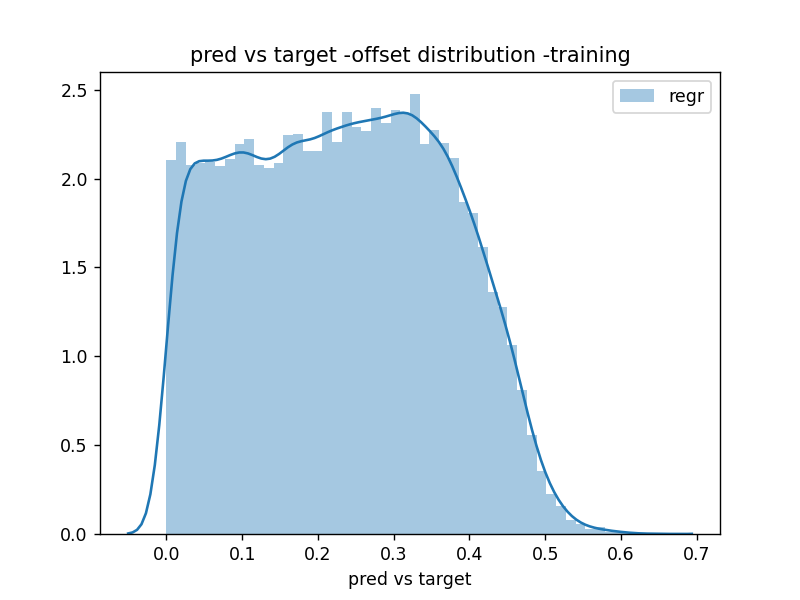

Text(0.5, 1.0, 'pred vs target -offset distribution -training')

In [12]:
%matplotlib notebook

ax =sns.distplot(abs(trainCmp['delta_or']), label='regr')
ax.legend()
ax.set_xlabel('pred vs target')
ax.set_title('pred vs target -offset distribution -training')

<IPython.core.display.Javascript object>


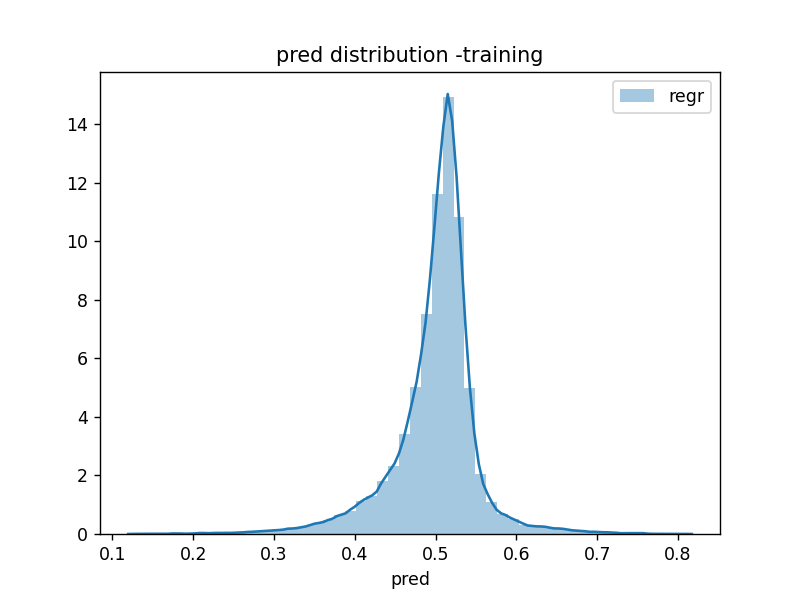

Text(0.5, 1.0, 'pred distribution -training')

In [13]:
%matplotlib notebook

ax =sns.distplot(abs(trainCmp['pred']), label='regr')
ax.legend()
ax.set_xlabel('pred')
ax.set_title('pred distribution -training')

                rmse
date                
2021-01-31  0.274819
2021-02-07  0.286047
2021-02-14  0.284295
2021-02-21  0.285279
2021-02-28  0.284192
2021-03-07  0.288807
2021-03-14  0.285772
2021-03-21  0.280362
2021-03-28  0.287733
2021-04-04  0.283970
2021-04-11  0.277266
2021-04-18  0.285293
2021-04-25  0.280940
2021-05-02  0.278520
2021-05-09  0.283104
2021-05-16  0.286958
2021-05-23  0.280135
2021-05-30  0.285470
2021-06-06  0.286114
2021-06-13  0.287900
2021-06-20  0.287814
2021-06-27  0.284001
2021-07-04  0.284547
2021-07-11  0.285349
2021-07-18  0.287421
2021-07-25  0.283270
2021-08-01  0.281619
2021-08-08  0.285322
2021-08-15  0.287977
2021-08-22  0.289874
2021-08-29  0.281838
2021-09-05  0.286701
2021-09-12  0.287193
2021-09-19  0.281899
2021-09-26  0.286702
2021-10-03  0.283607
2021-10-10  0.285061


<IPython.core.display.Javascript object>


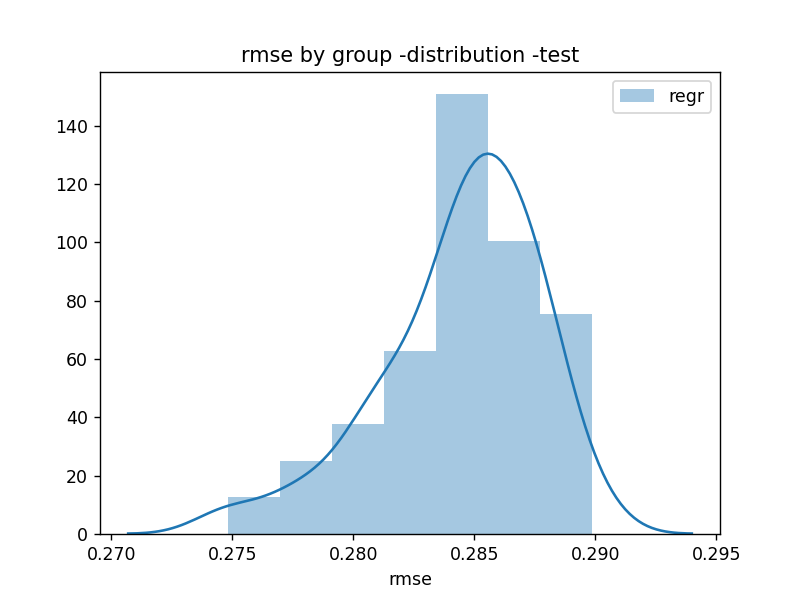

Text(0.5, 1.0, 'rmse by group -distribution -test')

In [14]:
predictionXG1 = pd.DataFrame()
predictionXG1['date'] = list(X_test.index)
predictionXG1.set_index(['date'],inplace=True)
predictionXG1['prediction'] = y_pred_test
predictionXG1['label']=y_test
predictionXG1['delta']=predictionXG1.prediction-predictionXG1.label
predictionXG1.prediction.max()
testCmp=predictionXG1.copy()
testCmp.columns=['pred','target','delta_or']
indexTestList=testCmp.index.unique().to_list()
groupSizeTest=pd.DataFrame(data={'groupSize':groups_eval}, index=indexTestList)
tesstCmp=testCmp.join(groupSizeTest, how='left')
testCmp.index.name='date'

np.sqrt(mean_squared_error(testCmp['pred'],testCmp['target']))
def rmse( g ):
    
    rmse = np.sqrt( mean_squared_error( g['target'], g['pred'] ) )
    return pd.Series( dict( rmse = rmse ) )
rmseTest=testCmp.groupby('date').apply(rmse)
print(rmseTest)

%matplotlib notebook
ax =sns.distplot(rmseTest ,label='regr')

ax.set_xlabel('rmse')
ax.legend()
ax.set_title('rmse by group -distribution -test')

<IPython.core.display.Javascript object>


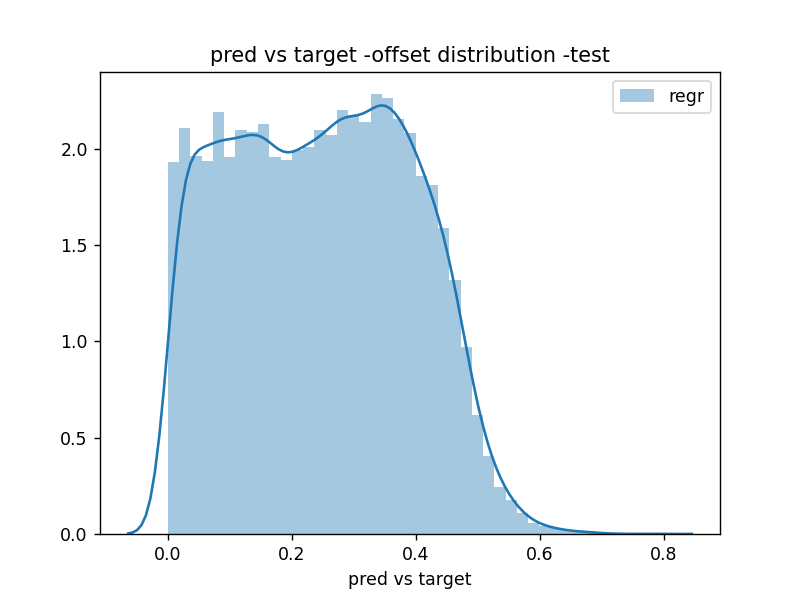

Text(0.5, 1.0, 'pred vs target -offset distribution -test')

In [15]:
%matplotlib notebook

ax =sns.distplot(abs(testCmp['delta_or']), label='regr')
ax.legend()
ax.set_xlabel('pred vs target')
ax.set_title('pred vs target -offset distribution -test')

<IPython.core.display.Javascript object>


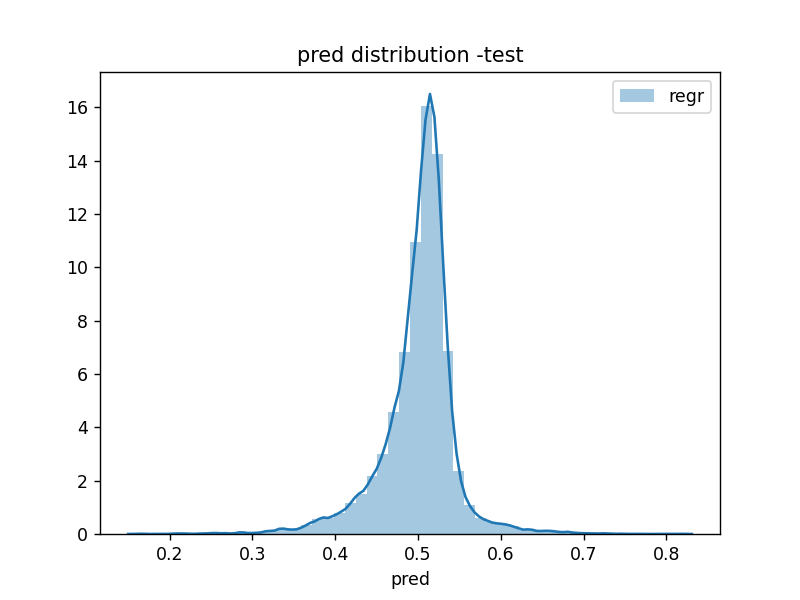

Text(0.5, 1.0, 'pred distribution -test')

In [16]:
%matplotlib notebook

ax =sns.distplot(abs(testCmp['pred']), label='regr')
ax.legend()
ax.set_xlabel('pred')
ax.set_title('pred distribution -test')

In [35]:
# Use the trained Logistic Regression model to make prediction on latest data

X_validation = validation_dataset.iloc[:, 1:-2]
y_validation = xgreg1.predict(X_validation)



0.66629213

In [36]:
prediction = pd.DataFrame()
prediction['symbol'] = list(validation_dataset.symbol)
prediction['prediction'] = y_validation
prediction.head()

,symbol,prediction
0,XRP,0.563633
1,MGO,0.526424
2,FUN,0.503034
3,USDT,0.532212
4,ETH,0.579041


In [37]:
#check if y_latest is in accordance to shape for submission
if set(prediction.symbol) == set(validation_dataset.symbol):
    print('symbol matched!')
else:
    print('symbol unmatched, the symbol in prediction df must match the symbol in validation_dataset...')
    
if prediction.shape[1] == 2:
    print('column counts ok!')
else:
    print('It should have 2 columns, first column with symbol, second with prediction...')


symbol matched!
column counts ok!


In [38]:
#Output submission as .csv file
prediction.to_csv('prediction/prediction_21_41.csv', index = False, header = None)